Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\MSI GF66/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:27<00:00, 3.78MB/s]


Epoch 1/20 - Train Loss: 0.8855, Val Loss: 0.6692, Accuracy: 0.7750, Precision: 0.7934, Recall: 0.7750
Epoch 2/20 - Train Loss: 0.5763, Val Loss: 0.5314, Accuracy: 0.8212, Precision: 0.8270, Recall: 0.8212
Epoch 3/20 - Train Loss: 0.4935, Val Loss: 0.4696, Accuracy: 0.8472, Precision: 0.8502, Recall: 0.8472
Epoch 4/20 - Train Loss: 0.4460, Val Loss: 0.4957, Accuracy: 0.8381, Precision: 0.8470, Recall: 0.8381
Epoch 5/20 - Train Loss: 0.4184, Val Loss: 0.4715, Accuracy: 0.8394, Precision: 0.8474, Recall: 0.8394
Epoch 6/20 - Train Loss: 0.2953, Val Loss: 0.3134, Accuracy: 0.8941, Precision: 0.8936, Recall: 0.8941
Epoch 7/20 - Train Loss: 0.2512, Val Loss: 0.3003, Accuracy: 0.8971, Precision: 0.8969, Recall: 0.8971
Epoch 8/20 - Train Loss: 0.2321, Val Loss: 0.2947, Accuracy: 0.9037, Precision: 0.9033, Recall: 0.9037
Epoch 9/20 - Train Loss: 0.2119, Val Loss: 0.2967, Accuracy: 0.9045, Precision: 0.9046, Recall: 0.9045
Epoch 10/20 - Train Loss: 0.2012, Val Loss: 0.2898, Accuracy: 0.9054, Pre

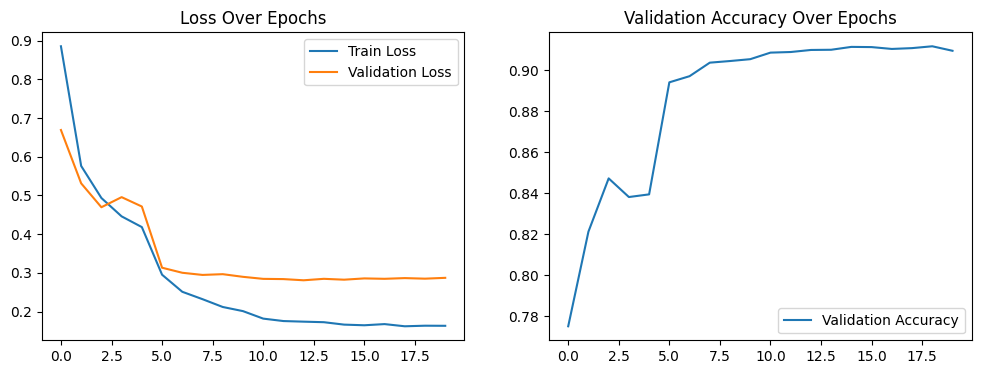

Final model saved to cifar10_final_model.pth


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import precision_score, recall_score

# Hyperparameters
batch_size = 128
epochs = 20
learning_rate = 0.001
model_name = "resnet50"

def get_data_loaders(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

def get_model(model_name):
    if model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif model_name == "vgg16":
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
    else:
        raise ValueError("Unsupported model name")

    for param in model.parameters():
        param.requires_grad = True

    return model

def train_and_evaluate(model, trainloader, testloader, epochs, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    train_losses, val_losses, val_accuracies = [], [], []
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(trainloader))

        model.eval()
        correct, total = 0, 0
        val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(testloader))
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)

        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), "best_model.pth")

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

        scheduler.step()

    return model, train_losses, val_losses, val_accuracies

def plot_metrics(train_losses, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title('Validation Accuracy Over Epochs')
    plt.show()

def save_model(model, path="cifar10_final_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Final model saved to {path}")


trainloader, testloader = get_data_loaders(batch_size)
model = get_model(model_name)
trained_model, train_losses, val_losses, val_accuracies = train_and_evaluate(model, trainloader, testloader, epochs, learning_rate)
plot_metrics(train_losses, val_losses, val_accuracies)
save_model(trained_model)
